In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

#Librerias para visualizacion
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
labels_training = pd.read_csv('/home/lucas/Documentos/Facultad/OrgaDeDatos/tp/labels_training_set.csv',
                              low_memory= False)
events_data = pd.read_csv('/home/lucas/Documentos/Facultad/OrgaDeDatos/tp/events_up_to_01062018.csv', 
                              low_memory= False)

In [3]:
#Data Frame de features
features = pd.DataFrame()

In [4]:
events_data.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
events_data.columns

Index(['timestamp', 'event', 'person', 'url', 'sku', 'model', 'condition',
       'storage', 'color', 'skus', 'search_term', 'staticpage',
       'campaign_source', 'search_engine', 'channel', 'new_vs_returning',
       'city', 'region', 'country', 'device_type', 'screen_resolution',
       'operating_system_version', 'browser_version'],
      dtype='object')

In [6]:
labels_training.head()

,person,label
0,0566e9c1,0
1,6ec7ee77,0
2,abe7a2fb,0
3,34728364,0
4,87ed62de,0


In [7]:
#En features tengo los usuarios sin repetir
features['person'] = events_data['person'].unique()

In [8]:
events_data['hour'] = pd.to_datetime(events_data['timestamp']).dt.hour
events_data['date'] = pd.to_datetime(events_data['timestamp']).dt.date

**Cantidad de conversiones por usuario**

In [9]:
conversions_user = pd.DataFrame()

In [10]:
conversions_user = events_data.loc[events_data['event'] == 'conversion',['person']]

In [11]:

conversions_user= pd.DataFrame(conversions_user['person'].value_counts())

In [12]:
conversions_user = conversions_user.reset_index()
conversions_user.rename({'index':'person', 'person':'cantidad de conversiones'}, axis = 1, inplace = True)
conversions_user.head()

,person,cantidad de conversiones
0,5059f7fd,129
1,888a11a2,44
2,0280a93d,32
3,b4cdf2b5,30
4,32c21f9e,21


In [13]:
features = features.merge(conversions_user, on = 'person', how = 'left')

In [14]:
features.head()

,person,cantidad de conversiones
0,4886f805,NaN
1,ad93850f,NaN
2,0297fc1e,NaN
3,2d681dd8,NaN
4,cccea85e,NaN


In [15]:
#features['cantidad de conversiones'] = features['cantidad de conversiones'].fillna(0) 

In [16]:
features.head(20)

,person,cantidad de conversiones
0,4886f805,NaN
1,ad93850f,NaN
2,0297fc1e,NaN
3,2d681dd8,NaN
4,cccea85e,NaN
5,4c8a8b93,NaN
6,1b9f7cf6,NaN
7,29ebb414,NaN
8,de8fe91b,NaN
9,45baf068,NaN


In [17]:
events_data['event'].value_counts()

viewed product       1248124
brand listing         216312
visited site          204069
ad campaign hit       191388
generic listing       160176
searched products     130616
search engine hit     106406
checkout               65315
staticpage             11201
conversion              7091
lead                     983
Name: event, dtype: int64

**Cantidad de veces que cada usuario vio un producto**

In [18]:
view_user = pd.DataFrame()
view_user = events_data.loc[events_data['event'] == 'viewed product',['person']]
view_user= pd.DataFrame(view_user['person'].value_counts())
view_user = view_user.reset_index()
view_user.rename({'index':'person', 'person':'cantidad de veces que vio un producto'}, axis = 1, inplace = True)
view_user.head()

,person,cantidad de veces que vio un producto
0,6abd2bf1,2355
1,b1f4dbf6,2233
2,8fb4929e,1912
3,06ed04d6,1881
4,bfb74b38,1782


In [19]:
features.head(10)

,person,cantidad de conversiones
0,4886f805,NaN
1,ad93850f,NaN
2,0297fc1e,NaN
3,2d681dd8,NaN
4,cccea85e,NaN
5,4c8a8b93,NaN
6,1b9f7cf6,NaN
7,29ebb414,NaN
8,de8fe91b,NaN
9,45baf068,NaN


In [20]:
features = features.merge(view_user, on = 'person', how = 'left')
#features['cantidad de veces que vio un producto'] = features['cantidad de veces que vio un producto'].fillna(0) 

In [21]:
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto
0,4886f805,NaN,4.0
1,ad93850f,NaN,20.0
2,0297fc1e,NaN,404.0
3,2d681dd8,NaN,13.0
4,cccea85e,NaN,739.0


**Cantidad de visitas a la pagina de cada usuario**

In [22]:
visit_user = pd.DataFrame()
visit_user = events_data.loc[events_data['event'] == 'visited site',['person']]
visit_user= pd.DataFrame(visit_user['person'].value_counts())
visit_user = visit_user.reset_index()
visit_user.rename({'index':'person', 'person':'cantidad de visitas a la pagina'}, axis = 1, inplace = True)
visit_user.head()

,person,cantidad de visitas a la pagina
0,5059f7fd,295
1,02f14240,294
2,67bdc946,210
3,7ac0c607,208
4,9b3b43aa,184


In [23]:
features = features.merge(visit_user, on = 'person', how = 'left')
#features['cantidad de visitas a la pagina'] = features['cantidad de visitas a la pagina'].fillna(0)
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto,cantidad de visitas a la pagina
0,4886f805,NaN,4.0,1.0
1,ad93850f,NaN,20.0,5.0
2,0297fc1e,NaN,404.0,95.0
3,2d681dd8,NaN,13.0,2.0
4,cccea85e,NaN,739.0,22.0


In [24]:
features['cantidad de veces que vio un producto'].isnull().any()

True

In [25]:
features['cantidad de visitas a la pagina'].isnull().any()

True

**Cantidad de visitas a la pagina de cada usuario**

In [26]:
check_user = pd.DataFrame()
check_user = events_data.loc[events_data['event'] == 'checkout',['person']]
check_user= pd.DataFrame(check_user['person'].value_counts())
check_user = check_user.reset_index()
check_user.rename({'index':'person', 'person':'cantidad de checkouts'}, axis = 1, inplace = True)
check_user.head()

,person,cantidad de checkouts
0,5059f7fd,197
1,a1b25eb0,101
2,043ec736,66
3,453b63ca,65
4,e1443dd4,64


In [27]:
features = features.merge(check_user, on = 'person', how = 'left')
#features['cantidad de checkouts'] = features['cantidad de checkouts'].fillna(0)
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto,cantidad de visitas a la pagina,cantidad de checkouts
0,4886f805,NaN,4.0,1.0,1.0
1,ad93850f,NaN,20.0,5.0,1.0
2,0297fc1e,NaN,404.0,95.0,7.0
3,2d681dd8,NaN,13.0,2.0,1.0
4,cccea85e,NaN,739.0,22.0,1.0


**Conversiones por hora del dia**

In [28]:
conversions_hour = pd.DataFrame()
conversions = events_data.loc[events_data['event'] == 'conversion',['hour']]

In [29]:
conversions['hour'].value_counts()

21    493
18    475
17    466
19    453
15    444
0     436
16    434
23    423
20    423
13    421
22    416
14    400
1     394
12    307
2     296
11    227
3     201
10    108
4      95
5      51
9      49
6      31
7      28
8      20
Name: hour, dtype: int64

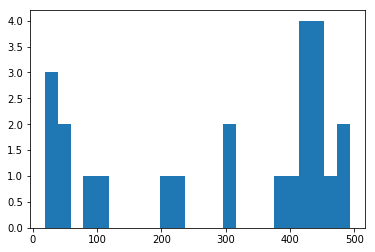

In [30]:
plt.hist(conversions['hour'].value_counts(),bins = 24);

**Veo cuantas veces vio cada uno de los 5 modelos mas vendidos segun lo obtenido en la exploracion del tp1**

Del menos la mas vendido
iPhone 6S, Samsung Galaxy S6 Flat, iPhone 6 , iPhone 5S, Samsung Galaxy J5

Veo por usuario cuantas veces vio uno de estos productos

In [31]:
viewed_product_event = pd.DataFrame()
viewed_product_event = events_data.loc[events_data['event'] == 'viewed product',['person', 'model']]

In [32]:
#samsung galaxy j5
samsung_j5 = pd.DataFrame()
samsung_j5 = viewed_product_event.loc[viewed_product_event['model'] == 'Samsung Galaxy J5',['person']]

In [33]:
samsung_j5= pd.DataFrame(samsung_j5['person'].value_counts())
samsung_j5 = samsung_j5.reset_index()
samsung_j5.rename({'index':'person', 'person':'cantidad de vistas del J5'}, axis = 1, inplace = True)
samsung_j5.head()

,person,cantidad de vistas del J5
0,5059f7fd,149
1,1775ba85,140
2,86742710,131
3,e68cc89a,110
4,9c743b65,107


In [34]:
features = features.merge(samsung_j5, on = 'person', how = 'left')
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto,cantidad de visitas a la pagina,cantidad de checkouts,cantidad de vistas del J5
0,4886f805,NaN,4.0,1.0,1.0,NaN
1,ad93850f,NaN,20.0,5.0,1.0,NaN
2,0297fc1e,NaN,404.0,95.0,7.0,NaN
3,2d681dd8,NaN,13.0,2.0,1.0,NaN
4,cccea85e,NaN,739.0,22.0,1.0,NaN


In [35]:
#iphone 5s
iPhone_5S = pd.DataFrame()
iPhone_5S = viewed_product_event.loc[viewed_product_event['model'] == 'iPhone 5s',['person']]
iPhone_5S= pd.DataFrame(iPhone_5S['person'].value_counts())
iPhone_5S = iPhone_5S.reset_index()
iPhone_5S.rename({'index':'person', 'person':'cantidad de vistas del iphone 5s'}, axis = 1, inplace = True)
iPhone_5S.head()

,person,cantidad de vistas del iphone 5s
0,b1f4dbf6,832
1,0d5f66ed,495
2,360feb42,406
3,c1aea85e,394
4,d6db0770,376


In [36]:
features = features.merge(iPhone_5S, on = 'person', how = 'left')
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto,cantidad de visitas a la pagina,cantidad de checkouts,cantidad de vistas del J5,cantidad de vistas del iphone 5s
0,4886f805,NaN,4.0,1.0,1.0,NaN,NaN
1,ad93850f,NaN,20.0,5.0,1.0,NaN,17.0
2,0297fc1e,NaN,404.0,95.0,7.0,NaN,1.0
3,2d681dd8,NaN,13.0,2.0,1.0,NaN,NaN
4,cccea85e,NaN,739.0,22.0,1.0,NaN,2.0


In [37]:
#iPhone 6
samsung_s6_flat = pd.DataFrame()
samsung_s6_flat = viewed_product_event.loc[viewed_product_event['model'] == 'Samsung Galaxy S6 Flat',['person']]
samsung_s6_flat= pd.DataFrame(samsung_s6_flat['person'].value_counts())
samsung_s6_flat = samsung_s6_flat.reset_index()
samsung_s6_flat.rename({'index':'person', 'person':'cantidad de vistas del samsung s6 flat'}, axis = 1, inplace = True)
samsung_s6_flat.head()

,person,cantidad de vistas del samsung s6 flat
0,a879f712,238
1,439d167c,225
2,5961db59,146
3,000e4d9e,139
4,595b9b50,117


In [39]:
features = features.merge(samsung_s6_flat, on = 'person', how = 'left')
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto,cantidad de visitas a la pagina,cantidad de checkouts,cantidad de vistas del J5,cantidad de vistas del iphone 5s,cantidad de vistas del samsung s6 flat
0,4886f805,NaN,4.0,1.0,1.0,NaN,NaN,NaN
1,ad93850f,NaN,20.0,5.0,1.0,NaN,17.0,NaN
2,0297fc1e,NaN,404.0,95.0,7.0,NaN,1.0,NaN
3,2d681dd8,NaN,13.0,2.0,1.0,NaN,NaN,NaN
4,cccea85e,NaN,739.0,22.0,1.0,NaN,2.0,1.0


In [40]:
#iPhone 6
iPhone_6 = pd.DataFrame()
iPhone_6 = viewed_product_event.loc[viewed_product_event['model'] == 'iPhone 6',['person']]
iPhone_6= pd.DataFrame(iPhone_6['person'].value_counts())
iPhone_6 = iPhone_6.reset_index()
iPhone_6.rename({'index':'person', 'person':'cantidad de vistas del iphone 6'}, axis = 1, inplace = True)
iPhone_6.head()

,person,cantidad de vistas del iphone 6
0,6abd2bf1,603
1,9bf968c5,558
2,c86f17ad,417
3,09ebd175,341
4,edbdffb9,318


In [41]:
features = features.merge(iPhone_6, on = 'person', how = 'left')
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto,cantidad de visitas a la pagina,cantidad de checkouts,cantidad de vistas del J5,cantidad de vistas del iphone 5s,cantidad de vistas del samsung s6 flat,cantidad de vistas del iphone 6
0,4886f805,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN
1,ad93850f,NaN,20.0,5.0,1.0,NaN,17.0,NaN,NaN
2,0297fc1e,NaN,404.0,95.0,7.0,NaN,1.0,NaN,213.0
3,2d681dd8,NaN,13.0,2.0,1.0,NaN,NaN,NaN,NaN
4,cccea85e,NaN,739.0,22.0,1.0,NaN,2.0,1.0,NaN


In [42]:
#iPhone 6s
iPhone_6s = pd.DataFrame()
iPhone_6s = viewed_product_event.loc[viewed_product_event['model'] == 'iPhone 6',['person']]
iPhone_6s= pd.DataFrame(iPhone_6s['person'].value_counts())
iPhone_6s = iPhone_6s.reset_index()
iPhone_6s.rename({'index':'person', 'person':'cantidad de vistas del iphone 6s'}, axis = 1, inplace = True)
iPhone_6s.head()

,person,cantidad de vistas del iphone 6s
0,6abd2bf1,603
1,9bf968c5,558
2,c86f17ad,417
3,09ebd175,341
4,edbdffb9,318


In [43]:
features = features.merge(iPhone_6s, on = 'person', how = 'left')
features.head()

,person,cantidad de conversiones,cantidad de veces que vio un producto,cantidad de visitas a la pagina,cantidad de checkouts,cantidad de vistas del J5,cantidad de vistas del iphone 5s,cantidad de vistas del samsung s6 flat,cantidad de vistas del iphone 6,cantidad de vistas del iphone 6s
0,4886f805,NaN,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,ad93850f,NaN,20.0,5.0,1.0,NaN,17.0,NaN,NaN,NaN
2,0297fc1e,NaN,404.0,95.0,7.0,NaN,1.0,NaN,213.0,213.0
3,2d681dd8,NaN,13.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
4,cccea85e,NaN,739.0,22.0,1.0,NaN,2.0,1.0,NaN,NaN
